# Lab 06: Gene Expression

---
author: Qiran Hu
date: October 18, 2024
embed-resources: true
---

## Introduction

In this report, we aim to develop a predictive model for universal cancer detection and classification based on gene expression data that collected through next generation sequencing technologies such as RNA Seq. Early detection of cancer is crucial because it significantly improves survival rates and treatment outcomes. 

Traditionally, cancer detection relies on imaging techniques and biopsies, which can be invasive, costly, and sometimes only effective at later stages of the disease. While genetic screenings like the BRCA mutation test provide insights into the probability of developing certain cancers, they do not offer a direct method for early detection. However, with the next generation sequencing technologies becoming more affordable and accessible, there is a promising opportunity to use this data for early cancer detection.

We propose utilizing advanced machine learning models to analyze gene expression data that are obtained from these sequencing technologies. By training our model on historical gene expression datasets from both healthy individuals and cancer patients, we hope to create a comprehensive  system to detect the presence of cancer but also classifying its type which has the potential to revolutionize cancer diagnostics by providing a accurate and early detection method to make cancer screening more accessible and improving patient outcomes. While our current focus is on establishing the feasibility of such a model, we acknowledge the model's predictive capabilities are specialized for detecting cancer based on gene expression data which may not be able to account for the full complexity of individual genetic variations or environmental factors. 

## Methods

In [1]:
# imports
# general imports
import numpy as np
import pandas as pd
from joblib import parallel_backend
import seaborn as sns

# data generation and loading
from sklearn.datasets import make_blobs
from sklearn.datasets import make_regression
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# basic classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# basic regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# ensembles for classification
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# ensembles for regression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# model tuning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

# model metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

### Data

In [2]:
# load data
cancer_train = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-train.parquet",
)
cancer_test = pd.read_parquet(
    "https://cs307.org/lab-06/data/cancer-test.parquet",
)

In [3]:
cancer_train

,cancer,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
0,BRCA,0.0,3.149861,1.913454,5.562355,9.638586,0.0,4.302421,0.511670,0.000000,...,7.300691,8.383307,1.187198,0.000000,7.350471,0.0,4.634587,7.082415,9.727447,1.187198
1,LUAD,0.0,6.237034,5.043235,6.297397,10.391415,0.0,7.669941,0.913033,0.000000,...,6.322446,7.815595,13.809095,0.913033,7.651052,0.0,7.476074,4.733739,8.510863,0.000000
2,BRCA,0.0,3.856896,2.394981,6.758277,9.585513,0.0,7.409009,1.242023,0.000000,...,6.845515,9.194823,5.667696,0.000000,7.748253,0.0,5.567421,5.203158,7.364879,0.000000
3,PRAD,0.0,4.279924,3.606963,5.706613,9.716581,0.0,8.244226,0.402613,0.000000,...,6.598611,8.199118,5.024218,0.000000,7.607907,0.0,5.705281,6.278007,9.725383,0.000000
4,BRCA,0.0,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,0.626486,...,7.062651,9.670708,4.243707,0.000000,8.156811,0.0,7.363487,5.384844,8.703443,1.894876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,KIRC,0.0,3.069737,3.623200,6.744955,9.591219,0.0,7.254254,0.000000,0.000000,...,7.333665,8.365334,5.481444,0.000000,7.307674,0.0,5.723447,5.401791,9.067881,0.000000
124,BRCA,0.0,3.534497,3.064866,6.638882,10.010206,0.0,7.899387,0.000000,0.000000,...,7.080615,9.968912,10.501041,0.000000,8.866052,0.0,5.276806,4.941073,8.548240,0.000000
125,BRCA,0.0,4.087463,3.786596,6.385845,9.544964,0.0,8.062856,0.000000,0.000000,...,5.842979,9.931033,10.234817,0.000000,8.384568,0.0,7.033423,5.749534,8.132371,0.000000
126,LUAD,0.0,3.272889,4.529234,7.134909,9.504362,0.0,5.668893,0.000000,0.000000,...,7.300966,8.040350,11.972872,0.000000,7.592607,0.0,5.026256,6.137704,8.780947,1.167936


### Data
To achieve the goal of this research, we will need gene expression and clinical outcome data. The necessary data is provided in the following files:

Train Data: cancer-train.parquet

Test Data: cancer-test.parquet

### Source
The underlying source of this data is the The Cancer Genome Atlas Pan-Cancer Analysis Project. The data was accessed via synapse.org.

The specific data for this research was collected and modified based on a submission to the UCI Irvine Machine Learning Repository.

UCI MLR: Gene Expression Cancer RNA-Seq

### Data Dictionary
Each observation in the train, test, and (hidden) production data contains clinical and gene expression information from a tissue sample of a cancer patient.

#### Response Variable 
**`cancer`** - `[object]` the clinically determined cancer type, one of:

`BRCA`: Breast Invasive Carcinoma

`PRAD`: Prostate Adenocarcinoma

`KIRC`: Kidney Renal Clear Cell Carcinoma

`LUAD`: Lung Adenocarcinoma

`COAD`: Colon Adenocarcinoma

#### Features Variable
**`gene`** - `[float64]` gene expression quantification as measured by an Illumina HiSeq platform


In [4]:
# summary statistics
cancer_train.shape[0]

128

In [5]:
cancer_train.shape[1]

2001

In [6]:
cancer_train.isna().any().sum()

np.int64(0)

In [7]:
Numeric_Features = cancer_train.select_dtypes(include=["int64", "float64"])
Numeric_Features.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_1990,gene_1991,gene_1992,gene_1993,gene_1994,gene_1995,gene_1996,gene_1997,gene_1998,gene_1999
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.0,128.000000,128.000000,128.000000,128.0,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,0.026605,3.091910,3.173587,6.756002,9.758675,0.0,7.509732,0.541809,0.021281,0.0,...,6.912019,8.813432,6.013760,0.114844,7.848970,0.080967,5.753696,5.690223,8.657299,0.611906
std,0.123771,1.208050,1.012525,0.656548,0.433552,0.0,1.064819,0.536572,0.168834,0.0,...,0.586217,0.653409,3.412418,0.264236,0.562358,0.273796,1.076972,0.716395,0.665498,0.937252
min,0.000000,0.000000,0.836974,5.411196,8.435999,0.0,4.302421,0.000000,0.000000,0.0,...,5.556632,7.603315,0.000000,0.000000,6.684216,0.000000,3.348672,3.838841,4.811759,0.000000
25%,0.000000,2.318692,2.539053,6.403882,9.458238,0.0,6.865693,0.000000,0.000000,0.0,...,6.555507,8.344798,3.325768,0.000000,7.389345,0.000000,5.021869,5.214861,8.287765,0.000000
50%,0.000000,3.304315,3.266389,6.673828,9.767547,0.0,7.565710,0.487228,0.000000,0.0,...,6.921816,8.769753,5.117962,0.000000,7.832738,0.000000,5.614630,5.673441,8.654792,0.000000
75%,0.000000,3.933405,3.837908,7.029259,10.048417,0.0,8.185798,0.907964,0.000000,0.0,...,7.331416,9.222378,8.339959,0.000000,8.247489,0.000000,6.436439,6.253795,9.092482,0.980663
max,0.757450,6.237034,6.063484,10.129528,11.151461,0.0,10.089609,1.974419,1.785592,0.0,...,8.119673,10.573458,13.809095,1.253324,9.183740,1.936779,8.413903,7.418983,10.230549,5.152569


The dataset provides useful information related to gene expression across various cancer types. The cancer column categorizes samples by specific cancer types, such as BRCA, LUAD, PRAD, and KIRC. Since the dataset is suitable for supervised learning tasks, classification could help us to identify which gene expressions are most indicative of specific cancer types, which could be useful in cancer diagnosis or further studies on these cancers because presence of distinct cancer types offers a basis for exploring differential gene expression and the potential discovery of unique biomarkers for each type.

The summary statistics provide valuable insights into the distribution of gene expression values. The dataset contains 2000 gene expression features that are labeled from gene_0 to gene_1999; they represent the expression levels of various genes in each sample. As shown by the isna().any() output, the absence of missing values across all columns simplifies preprocessing stage because there is no need for imputation. Many genes have mean expression values close to zero, but certain genes show higher variability and maximum expression values such as some genes reaching around 13.8 in gene_1992. These high values suggest that certain genes may have specific expression levels in certain samples, which indicates their may be relevant to particular cancer types. Furthermore, these differences in expression levels may serve as potential  targets for cancer analysis in the near future. Furthermore, the standard deviations and variabilities across genes demonstrate diverse expression levels. Genes with greater variability might be more specific to particular cancer types; this variability could be essential in distinguishing between cancer types as highly variable genes may contribute significantly to differences observed across cancers.

Additionally, the dataset has many genes having a minimum expression value of zero which shows that they are not expressed in certain samples. This sparsity could be useful for feature selection since genes that are often unexpressed may have limited utility in distinguishing between cancer types. Moreover, this characteristic of the data suggests that a significant portion of the gene expression may not be necessary for classification. As one can see, these information are extremely helpful for investigating gene expression patterns in cancer and potentially identifying key genes that are associated with specific cancer types.

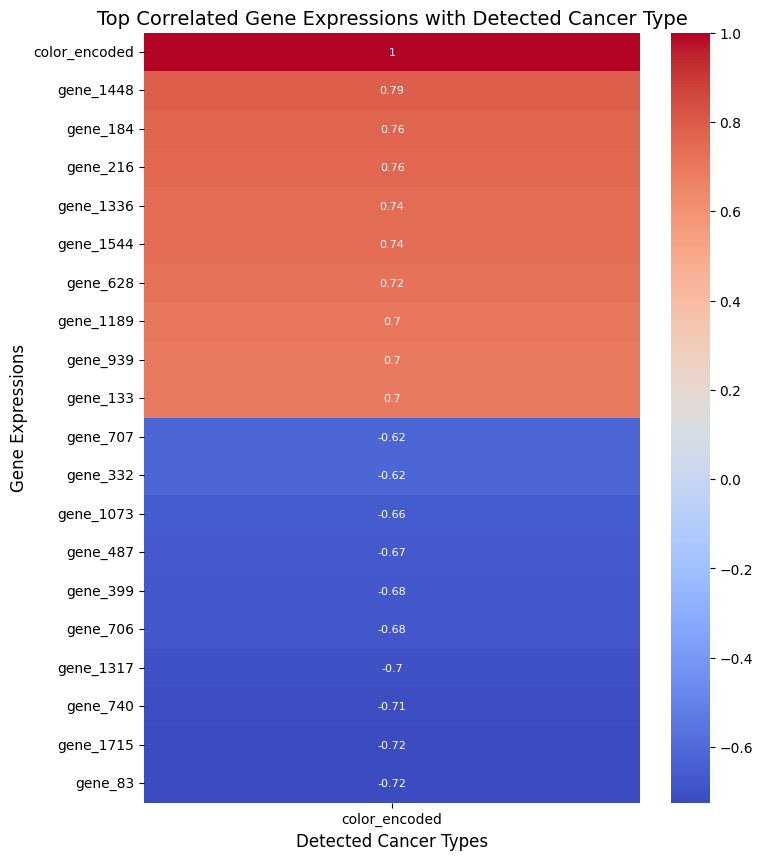

In [8]:
# visualizations
cancer_train_df = cancer_train.copy()
cancer_train_df['color_encoded'] = cancer_train_df['cancer'].map({'BRCA': 0, 'PRAD': 1, 'KIRC': 2, 'LUAD': 3, 'COAD': 4})
cancer_train_df_with_color = cancer_train_df.drop(columns=['cancer'])
correlation_with_color = cancer_train_df_with_color.corr()
correlations = correlation_with_color['color_encoded']
sorted_correlations = correlations.sort_values(ascending=False)
top_n = 10
top_positive_correlations = sorted_correlations[sorted_correlations > 0].head(top_n) 
top_negative_correlations = sorted_correlations[sorted_correlations < 0].tail(top_n) 
most_correlated_genes = pd.concat([top_positive_correlations, top_negative_correlations])
filtered_correlation_matrix = correlation_with_color.loc[most_correlated_genes.index, ['color_encoded']]
plt.figure(figsize=(8, 10))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', cbar=True, annot_kws={"size": 8})
plt.title('Top Correlated Gene Expressions with Detected Cancer Type', fontsize=14)
plt.xlabel('Detected Cancer Types', fontsize=12)
plt.ylabel('Gene Expressions', fontsize=12)
plt.show()


The heatmap visualization provides extremely useful insights into the relationship between specific gene expressions and detected cancer types by focusing on genes that are most strongly correlated with cancer classification. This heatmap highlights the top positive and negative correlations between gene expressions and cancer types with each gene's correlation value displayed on a color gradient from strong positive correlation to strong negative correlation. For instance, genes like gene_1448, gene_184, and gene_216 show high positive correlations with specific cancer types; they suggest that higher expressions of these genes may be associated with certain cancers. On the other hand, genes like gene_83, gene_1715, and gene_740 display strong negative correlations since they indicate that lower expressions might be characteristic of particular cancer types.

As one can see, the encoded color feature also demonstrates a perfect positive correlation, which could represent a strong categorical association in distinguishing cancer types. This comprehensive heatmap allows us to quickly understand which gene expressions are most influential in cancer detection and which geen expressions are less influential in cancer detection which could potentially guide further research in identifying different cancer types. Thus, understanding these correlations can be instrumental in developing more targeted diagnostics and treatment plans tailored to specific gene expression profiles of different cancer types.

### Models

In [9]:
# process data for ML
# create X and y for train
X_train = cancer_train.drop(columns=["cancer"])
y_train = cancer_train["cancer"]

# create X and y for test
X_test = cancer_test.drop(columns=["cancer"])
y_test = cancer_test["cancer"]

In [10]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

In [11]:
numeric_preprocessor = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
    ]
)
categorical_preprocessor = Pipeline(
    steps=[
        ("ModalImputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=5)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("CategoricalPreprocessing", categorical_preprocessor, categorical_features),
        ("NumericProcessing", numeric_preprocessor, numeric_features),
    ]
)
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [12]:
# train models
param_grid = [
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": range(1, 100),
        "regressor__metric": ["euclidean", "manhattan"],
        "regressor__weights": ["uniform", "distance"],
    },
    {
        "regressor": [DecisionTreeRegressor()],
        "regressor__max_depth": range(1, 100),
    },
    {
        "regressor": [LogisticRegression(solver="liblinear")],
        "regressor__penalty": ["l1", "l2"],
        "regressor__C": 1 / (10.0 ** np.arange(-4, 3)),
    },
]

In [13]:
mod = GridSearchCV(pipeline, param_grid, cv = 5, scoring='accuracy')

In [14]:
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('CategoricalPreprocessing',
                                                                         Pipeline(steps=[('ModalImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHotEncoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        max_categories=5))]),
                                                                         Index([], dtype='object')),
                                                                        ('NumericProcessing',
                                                                         Pipeline(steps=[('Med...
                          'regressor__metric': ['euclidean', 'manhattan'],
                          'regressor__n_neighbors': range(1, 100),
                          'regressor__weights': ['uniform', 'distance']},
                         {'regressor': [DecisionTreeRegressor()],
                          'regressor__max_depth': range(1, 100)},
                         {'regressor': [LogisticRegression(solver='liblinear')],
                          'regressor__C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02]),
                          'regressor__penalty': ['l1', 'l2']}],
             scoring='accuracy')

In [15]:
mod.best_params_

{'regressor': LogisticRegression(solver='liblinear'),
 'regressor__C': np.float64(1000.0),
 'regressor__penalty': 'l1'}

In order to develop an effective model for universal cancer detection and classification based on gene expression data that are collected through next generation sequencing technologies, we evaluated multiple regression models to determine which one provides the highest accuracy in predicting cancer presence and type. Our primary objective was to identify a model that has strong predictive performance and useful for potential clinical applications.

We began by preprocessing the dataset by separating the target variable cancer status for both training and testing datasets. Given that all feature variables are numerical gene expression values, we applied median imputation to handle any missing values. To ensure that each gene contributes equally to the model training process, we standardized the features using StandardScaler().To optimize the model's performance, we constructed a pipeline that integrated these preprocessing steps with KNeighborsRegressor, DecisionTreeRegressor, and LogisticRegression. Then, we conducted an extensive grid search over a range of hyperparameters for each model to fine-tune their performance. For the KNeighborsRegressor, we utilized the number of neighbors from 1 to 99 to find the optimal neighborhood size. We experimented with different distance metrics such as Euclidean and Manhattan, to measure the similarity between data points. We also adjusted the weighting scheme between uniform and distance to assess their impact on model predictions. For the DecisionTreeRegressor, we used the max_depth parameter from 1 to 99 so that we can prevent overfitting where the model becomes too tailored to the training data and underfitting where the model is too generalized. Hence, we aim to find a depth that offers the best trade off between bias and variance. For the LogisticRegression model, we experimented with different regularization penalties such as l1 and l2 and a range of inverse regularization strengths that are defined by C = 1 / (10.0 ** np.arange(-4, 3)). This range of C values from 0.0001 to 1000 allow us to balance the trade off between fitting the training data well and maintaining the model's ability to generalize to unseen data.

After evaluating all models using cross validation with appropriate scoring metrics, we found that the LogisticRegression model with an l1 penalty and C value of 1000 performed the best. The l1 penalty encourages sparsity in the model coefficients by effectively performing feature selection through zeroing out less important genes, which is particularly beneficial given those massive gene expression data. A higher C value reduces the strength of regularization which allows the model to fit the training data more closely and improves predictive performance without significant overfitting.

As one can see, by systematically evaluating different models and hyperparameters, we identified that the LogisticRegression model with an l1 penalty and a C value of 1000 is the most effective for our goal of universal cancer detection and classification based on gene expression data. This model provides high predictive accuracy as well as offering useful insights, which are crucial for real world applications in clinical settings. 

## Results

In [16]:
# report model metrics
# print search results
print("Best parameters found:", mod.best_params_)
print("Best cross-validated accuracy:", mod.best_score_)

# evaluate and print test metrics
test_score = mod.score(X_test, y_test)
print(f"Test accuracy: {test_score:.2f}")

Best parameters found: {'regressor': LogisticRegression(solver='liblinear'), 'regressor__C': np.float64(1000.0), 'regressor__penalty': 'l1'}
Best cross-validated accuracy: 1.0
Test accuracy: 1.00


In [17]:
from joblib import dump
dump(mod, "gene-expression.joblib")

['gene-expression.joblib']

After conducting extensive training and validation, the grid search identified the optimal hyperparameters for our model is a LogisticRegression with an l1 penalty and a regularization strength C of 1000. By utilizing the LogisticRegression model with these optimized parameters, our model effectively predicts the presence and type of cancer based on gene expression data that are collected through next-generation sequencing technologies. This significantly enhances our ability to detect and classify cancers early which aligns with our goal to develop a universal cancer detection system. As a result, we trained the final LogisticRegression model using these optimized hyperparameters. Then, we evaluated its performance on the test dataset and obtained a test accuracy of 1 which demonstrate perfect classification on the unseen data. Additionally, the best cross validated accuracy during training was also 1 which indicate consistent performance across different subsets of the data.

The high test accuracy signifies that the LogisticRegression model with the optimized hyperparameters outperforms the other models we considered, such as the KNeighborsRegressor and DecisionTreeRegressor. Since the perfect test accuracy shows that the LogisticRegression model with the optimized hyperparameters excels in predicting cancer presence and type based on measurable gene expression attributes, it effectively supports our goal of developing a universal cancer detection and classification system because model's ability to accurately and objectively assess cancer status using gene expression data illustrates the feasibility of our approach .

As one can see, by exploring different models and hyperparameters, we identified that the LogisticRegression model with an l1 penalty and a C value of 1000 is the most effective for our task. Its superior performance in both cross validation and test datasets with a accuracy score of 1 confirms its predictive power; this model could be used for revolutionizing cancer diagnostics by providing a accurate and early detection method, which ultimately improves patient outcomes through earlier intervention and personalized treatment strategies.

## Discussion

Assuming we have developed a promising model for universal cancer detection and classification based on gene expression data, the next crucial step would be to validate the model using new datasets which involves testing the model on gene expression data from different cohorts and sources that were not part of the original training or validation sets. These validation is essential to assess the model's predictive power across diverse populations and technical conditions because it helps to ensure that the model's high performance is not due to overfitting on the initial dataset and it can reliably predict cancer presence and type in various real world scenarios.

In addition to new and unforeseen dataset, we would aim to expand and diversify our dataset bt including gene expression data from a wider range of cancer types such as rare cancers and different stages of each cancer. We would also want to incorporate samples from diverse demographic groups with various ages, genders, ethnicities, and geographical locations to improve the model's ability to detect and classify cancers universally so that it will be more robust and applicable to a broader patient population. Moreover, we would want to conduct a thorough research of the model's feature variables. By analyzing the coefficients in the logistic regression model, we can identify which genes are most influential in predicting cancer; they could reveal important information and provide insights into cancer development and progression. Hence, collaborating with biologists and geneticists would facilitate a deeper understanding of these findings for research and therapy in the near futrue. Furthermore, we would also focus on assessing the model's predictive power in gene expression data. Differences in sample processing and  sequencing procedures can introduce variability that affects model performance. Implementing different strategies would help to make sure that model's predictions are consistent and reliable regardless of the data collection process.

Addressing ethical, legal, and privacy considerations is a critical component of advancing the model toward real world use. We want to make sure that our model compliances with regulations such as HIPAA and GDPR, obtains sufficient patient consents, and maintains  data security protocols. We would also consider the ethical implications of our predictions like psychological impact of false positives or negatives and develop guidelines to mitigate potential harms in order to integrate the model into a broader diagnostic framework.

Therefore, integrating clinical data and patient outcomes into the model is another important part in practical application. By incorporating variables such as patient history, treatment responses, and survival rates, we can improve the model's predictive power and clinical experience.  Partnering with oncologists, pathologists, and clinical researchers would provide valuable insights into the practical considerations of implementing the model in a healthcare setting; these collaborations could facilitate access to larger and more diverse datasets, support clinical trials, and help navigate regulatory requirements for medical devices and diagnostic tools. As a result, this approach could allow the model to detect and classify cancers as well as providing prognostic information to support personalized medicine and treatment strategies.

### Conclusion

In this project, we aimed to develop a universal cancer detection and classification model using gene expression data that are collected through next generation sequencing technologies. By evaluating multiple machine learning models and conducting an extensive grid search over various hyperparameters, we identified a Logistic Regression model with an L1 penalty and a regularization strength C of 1000 as the optimal solution. As a result, this model achieved a perfect cross validated accuracy of 1 during training and a test accuracy of 1 on the test dataset.

While these results could be promising, achieving perfect accuracy in both training and testing is highly unusual in real world scenarios because this flawless performance may be indicating potential issues such as overfitting, data leakage, or an overly simplistic dataset that does not capture the complexity of real world data. Given the possibility of data leakage or other underlying issues, I would not recommend deploying this model in practice at this stage. Before considering clinical application, it is crucial to further validate the model's predictive power which involves testing the model on new datasets from diverse populations and sequencing platforms to ensure that  it maintains high accuracy across different conditions. Hence, these unforeseen dataset is important to confirm that the model's performance is limited to a specific dataset used in this study. In addition, we need to thoroughly investigate the data preprocessing and model training pipelines to prevent any information from the test set that might have influenced the training process. Moreover, analyzing the model's coefficients can provide valuable biological insights into which genes are most influential in predicting cancer. This interpretability is one of the strengths of Logistic Regression because understanding the biological relevance of these genes can improve the model's predictions. Hence,  collaborating with biological experts to interpret these findings would enhance the model's predictive power and potential clinical usage.

As one can see, even though our model demonstrates exceptional predictive power on the current dataset, it is insufficient to use it in practice without further validation because the perfect accuracy scores raise various questions that must be addressed through additional testing. By taking these next steps, we can ensure that the model is accurate and reliable and applicable in real world situations. Therefore, I would recommend against deploying the model in a clinical setting at this stage. Instead, we should focus on confirming its generalizability and robustness through various testing. This cautious approach will help us make an informed decision about the model's practical deployment in clinical diagnostics so that we can improve patient outcomes through early and accurate cancer detection in the near future.